In [26]:
!pip install ml_collections "textdistance[extras]"

In [27]:
# hw2/utils.py

import enum
import pickle

import matplotlib.pyplot as plt
import numpy as np


def save_obj(obj, path):
    with open(path, "wb") as f:
        pickle.dump(obj, f)


def save_txt(str, path):
    with open(path, "w", encoding="utf-8") as f:
        f.write(str)


def load_metrics(file_path):
    with open(file_path, "rb") as f:
        metrics = pickle.load(f)

    return metrics


def plot_metrics(metrics, plot_path, phase="train"):
    metric_keys = list(metrics[0][phase].keys())
    len_x = len(metrics)
    x_label = "epoch".title()
    x = np.arange(len_x)

    for k in metric_keys:
        if k == "n":
            continue

        metric_path = plot_path / f"{k}__{phase}.pdf"
        y = np.array([metrics[i][phase][k] for i in range(len_x)])

        if k != "loss":
            batch = np.array([metrics[i][phase]["n"] for i in range(len_x)])
            y /= batch

        y = y.mean(axis=-1)
        _create_plot([y], [x], x_label, k.title(), metric_path, show=True)


def cmp_phase_metrics(metrics, key, phases, plot_path, labels):
    len_x = len(metrics)
    x_label = "epoch".title()
    x = np.arange(len_x)
    y = []

    for phase in phases:
        y_phase = np.array([metrics[i][phase][key] for i in range(len_x)])

        if key != "loss":
            batch = np.array([metrics[i][phase]["n"] for i in range(len_x)])
            y_phase /= batch

        y_phase = y_phase.mean(axis=-1)
        y.append(y_phase)

    x = [x] * len(y)
    fig_path = plot_path / f"{key}__{'_'.join(phases)}.pdf"
    labels = [labels[p] for p in phases]
    _create_plot(y, x, x_label, key.title(), fig_path, line_labels=labels, show=True)


def _create_plot(ys, xs, x_label, y_label, save_path, line_labels=None, show=False):
    fig, ax = plt.subplots()
    for y, x in zip(ys, xs):
        ax.plot(x, y)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.grid()
    fig.savefig(save_path, format="pdf", bbox_inches="tight")

    if line_labels is not None:
        ax.legend(line_labels)

    if show:
        plt.show(fig)

    plt.close(fig)


class Dataset(str, enum.Enum):
    LJSPEECH_STFT = "ljspeech_stft"
    LJSPEECH_MEL = "ljspeech_mel"


class DataSplit(str, enum.Enum):
    TRAIN = "train"
    VALIDATION = "validation"
    TEST = "test"


class AudioTransformType(str, enum.Enum):
    STFT = "stft"
    LOG_MEL_STFT = "log_mel_stft"


class EncoderType(str, enum.Enum):
    RNN = "rnn"
    TRANSFORMER = "transformer"


class DecoderType(str, enum.Enum):
    RNN = "rnn"
    TRANSFORMER = "transformer"


In [28]:
# hw2/config.py

from ml_collections import config_dict


def get_config():
    config = config_dict.ConfigDict()
    config.seed = 42
    config.n_fft = 400
    config.n_vocab = 35
    config.text_len = 99
    config.audio_freq = 80  # number of mel filters
    config.audio_time = 2754  # 10 seconds of sound
    config.epochs = 15
    config.lr = 1e-3
    config.unk_token_idx = 3
    config.storage_folder = "./storage"
    config.speech_to_text = dict(
        max_text_len=config.get_ref("text_len"),
        encoder_kwargs=dict(
            n_layers=2,
            freq_dim=config.get_ref("audio_freq"),
            time_dim=config.get_ref("audio_time") // 2,
            hidden_dim=200,
            n_heads=2,
            feed_fwd_dim=400,
        ),
        decoder_type=DecoderType.TRANSFORMER,
        decoder_kwargs=dict(
            freq_dim=config.get_ref("n_vocab"),
            time_dim=config.get_ref("text_len"),
            hidden_dim=200,
            n_heads=2,
            feed_fwd_dim=400,
        ),
    )

    config.data = dict(
        data_folder="./data/",
        data_split=dict(train=(0, 9825), validation=(9825, 10480), test=(10480, 13100)),
        dataloader=dict(
            train=dict(batch_size=64, shuffle=True, num_workers=2, prefetch_factor=2),
            validation=dict(
                batch_size=16, shuffle=False, num_workers=2, prefetch_factor=2
            ),
            test=dict(
                batch_size=16, shuffle=False, num_workers=2, prefetch_factor=2
            ),
        ),
        transforms=dict(
            audio=dict(
                spectrogram=dict(
                    n_fft=config.get_ref("n_fft"),
                    hop_length=160,
                    power=2,
                    center=True,
                    normalized=False,
                    onesided=None,
                ),
                mel_scale=dict(
                    n_mels=config.get_ref("audio_freq"),
                    n_stft=config.get_ref("n_fft") // 2 + 1,
                    norm="slaney",
                    mel_scale="slaney",
                ),
                pad=dict(
                    l=0,
                    t=0,
                    r=config.get_ref("audio_time"),
                    b=0,
                ),
                freq_masking=dict(freq_mask_param=27),
                time_masking=dict(time_mask_param=80),
            ),
            text=dict(
                token_vectorizer=dict(
                    max_len=config.get_ref("text_len"),
                    start="<",
                    stop=">",
                    empty="@",
                    unk="#",
                    n_vocab=config.get_ref("n_vocab"),
                )
            ),
        ),
    )

    return config.lock()


In [29]:
# hw2/data.py

import functools
import os
from typing import Callable, Dict, List, Tuple

from ml_collections import config_dict
import torch
import torchaudio
import torchvision


class TokenVectorizer(torch.nn.Module):
    def __init__(
        self,
        n_vocab: int,
        max_len: int = 50,
        start: str = "<",
        stop: str = ">",
        empty: str = "@",
        unk: str = "#",
    ) -> None:
        super().__init__()
        self._max_len = max_len
        self._start = start
        self._stop = stop
        self._empty = empty
        self._unk = unk
        self._vocab = [" ", ",", ".", "?", "-"]
        self._vocab += [chr(i + 96) for i in range(1, 27)]

        assert self._start not in self._vocab
        assert self._stop not in self._vocab
        assert self._empty not in self._vocab
        assert self._unk not in self._vocab
        self._vocab = [self._start, self._stop, self._empty, self._unk] + self._vocab
        assert len(self._vocab) == n_vocab
        self._unk_idx = 3
        self._mapper = {c: i for i, c in enumerate(self._vocab)}
        self._inv_mapper = {v: k for k, v in self._mapper.items()}

    def forward(self, transcript: str) -> torch.Tensor:
        transcript = transcript.lower()[: self._max_len - 2]
        transcript = self._start + transcript + self._stop
        pad = [self._mapper[self._empty]] * (self._max_len - len(transcript))
        return torch.tensor(
            [self._mapper.get(c, self._unk_idx) for c in transcript] + pad
        )

    @property
    def invert_mapper(self) -> Dict[int, str]:
        return self._inv_mapper

    @property
    def mapper(self) -> Dict[str, int]:
        return self._mapper

    @property
    def vocab(self) -> List[str]:
        return self._vocab


class SpeechRecognitionDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        ds: torch.utils.data.Dataset,
        get_el: Callable,
        audio_transforms: torch.nn.Module,
        text_transforms: torch.nn.Module,
    ):
        self._orig_ds = ds
        self._get_el = get_el
        self._audio_tf = audio_transforms
        self._text_tf = text_transforms

    def __getitem__(self, idx):
        audio, text = self._get_el(self._orig_ds, idx)
        audio = self._audio_tf(audio)
        text = self._text_tf(text)
        return audio, text

    def __len__(self):
        return len(self._orig_ds)


def _get_ljspeech_el(
    ds: torch.utils.data.Dataset, idx: int
) -> Tuple[torch.Tensor, torch.Tensor]:
    el = ds[idx]
    return el[0], el[-1]


def _log_mel_stft_transforms(config: config_dict.ConfigDict) -> torch.nn.Module:
    def log_mel(x):
        log_x = torch.clamp(x, min=1e-10).log10()
        log_x = torch.maximum(log_x, log_x.max() - 8.0)
        log_x = (log_x + 4.0) / 4.0
        return log_x

    return torchvision.transforms.Compose(
        [
            functools.partial(torch.squeeze, dim=0),
            torchaudio.transforms.Spectrogram(**config.spectrogram),
            torchaudio.transforms.MelScale(**config.mel_scale),
            log_mel,
            torchvision.transforms.Pad(
                (config.pad.l, config.pad.t, config.pad.r, config.pad.b)
            ),
            lambda x: x[..., :, : config.pad.r],
        ]
    )


def build_dl(
    split: DataSplit, config: config_dict.ConfigDict
) -> torch.utils.data.DataLoader:
    os.makedirs(config.data_folder, exist_ok=True)
    orig_ds = torchaudio.datasets.LJSPEECH(config.data_folder, download=True)
    get_el = _get_ljspeech_el
    audio_tf = _log_mel_stft_transforms(config.transforms.audio)
    text_tf = TokenVectorizer(**config.transforms.text.token_vectorizer)

    ds = torch.utils.data.Subset(orig_ds, range(*config.data_split.get(split)))
    ds = SpeechRecognitionDataset(ds, get_el, audio_tf, text_tf)
    dl = torch.utils.data.DataLoader(ds, **config.dataloader.get(split))
    return dl



In [37]:
# hw2/model.py

from typing import Any, Optional, Tuple

from ml_collections import config_dict
import numpy as np
import torch


class SpeechToText(torch.nn.Module):
    def __init__(
        self,
        max_text_len: int,
        encoder_kwargs: config_dict.ConfigDict,
        decoder_type: DecoderType,
        decoder_kwargs: config_dict.ConfigDict,
    ) -> None:
        """
        text_freq_dim is the vocabulary size.
        """
        super().__init__()
        self._max_text_len = max_text_len
        self._enc = AudioEncoderTransformer(**encoder_kwargs)
        self._dec, self._single_input = self._decoder_factory(
            decoder_type, decoder_kwargs
        )

    def forward(
        self, audio_feat: torch.Tensor, text_feat: torch.Tensor
    ) -> torch.Tensor:
        return self._dec(text_feat, self._enc(audio_feat))

    @torch.no_grad()
    def generate(self, audio_feat: torch.Tensor) -> torch.Tensor:
        enc_feat = self._enc(audio_feat)
        text = last_token = torch.zeros(
            (enc_feat.shape[0], 1), dtype=torch.long, device=enc_feat.device
        )  # vocab index of start token `<` = 0
        start_token = True

        for _ in range(self._max_text_len - 1):
            dec_input = last_token if self._single_input else text
            logits = self._dec.generate(dec_input, enc_feat, start_token)
            tokens = torch.argmax(logits, dim=-2)
            last_token = tokens[:, -1:]
            text = torch.concat([text, last_token], axis=-1)
            start_token = False

        return text

    def _decoder_factory(
        self, decoder_type: DecoderType, kwargs: config_dict.ConfigDict
    ) -> torch.nn.Module:
        if decoder_type == DecoderType.RNN:
            return TextDecoderRecurrent(**kwargs), True
        elif decoder_type == DecoderType.TRANSFORMER:
            return TextDecoderTransformer(**kwargs), False
        else:
            raise ValueError(f"Decoder type `{decoder_type}` is not valid.")


class AudioEncoderTransformer(torch.nn.Module):
    def __init__(
        self,
        n_layers: int = 2,
        freq_dim: int = 129,
        time_dim: int = 2754,
        hidden_dim: int = 64,
        n_heads: int = 2,
        feed_fwd_dim: int = 128,
        **kwargs,
    ) -> None:
        super().__init__()
        del kwargs
        self._embed = SpeechEmbedding(freq_dim, hidden_dim)  # audio embed
        self.register_buffer("_pos_embed", self._pos_encoding(time_dim, hidden_dim))
        self._att_blocks = torch.nn.ModuleList(
            [
                ResidualAttentionBlock(hidden_dim, n_heads, feed_fwd_dim)
                for _ in range(n_layers)
            ]
        )
        self._out_norm = torch.nn.LayerNorm(hidden_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = x  # (B, F, T)
        out = self._embed(out)
        out = out + self._pos_embed

        for block in self._att_blocks:
            out = block(out)

        out = self._out_norm(out)
        return out  # (B, T, E)

    def _pos_encoding(
        self, length: int, channels: int, max_timescale: int = 3000
    ) -> torch.Tensor:
        """Returns sinusoids for positional embedding"""
        assert channels % 2 == 0
        log_timescale_increment = np.log(max_timescale) / (channels // 2 - 1)
        inv_timescales = torch.exp(
            -log_timescale_increment * torch.arange(channels // 2)
        )
        scaled_time = (
            torch.arange(length)[:, np.newaxis] * inv_timescales[np.newaxis, :]
        )
        return torch.cat([torch.sin(scaled_time), torch.cos(scaled_time)], dim=1)


class TextDecoderTransformer(torch.nn.Module):
    def __init__(
        self,
        freq_dim: int = 35,
        time_dim: int = 50,
        hidden_dim: int = 64,
        n_heads: int = 2,
        feed_fwd_dim: int = 128,
        **kwargs,
    ) -> None:
        super().__init__()
        del kwargs
        self._embed = torch.nn.Embedding(freq_dim, hidden_dim)
        self._pos_embed = torch.nn.Parameter(torch.rand(time_dim - 1, hidden_dim))
        self._att = ResidualAttentionLayer(hidden_dim, n_heads, feed_fwd_dim)
        self._cross_att = ResidualAttentionBlock(hidden_dim, n_heads, feed_fwd_dim)
        self._out_norm = torch.nn.LayerNorm(hidden_dim)
        self._classifier = torch.nn.Linear(hidden_dim, freq_dim)
        mask = torch.empty(time_dim, time_dim).fill_(-np.inf).triu_(1)
        self.register_buffer("_mask", mask, persistent=False)

    def forward(self, x: torch.Tensor, latent: torch.Tensor) -> torch.Tensor:
        # in: x=(B, T_d), T_d: text length (max: 50 tokens)
        # in: latent=(B, T_e, H_e), see AudioEncoderTransformer
        # out: (B, F_d, T_d), F_d: text freq = num of vocab tokens
        # NOTE: when adding `self._pos_embed` don't forget to index its first dimension to have the same size as the input's text length `T_d`.
        emb = self._embed(x) + self._pos_embed[:x.shape[1],:]
        out = self._out_norm(self._cross_att(self._att(emb, self._mask), latent))   
        return self._classifier(out).permute(0,2,1)


    def generate(
        self, x: torch.Tensor, latent: torch.Tensor, start_token: bool = False
    ) -> torch.Tensor:
        return self.forward(x, latent)


class TextDecoderRecurrent(torch.nn.Module):
    def __init__(
        self,
        n_layers: int = 2,
        freq_dim: int = 35,
        hidden_dim: int = 64,
        n_heads: int = 2,
        feed_fwd_dim: int = 128,
        **kwargs,
    ) -> None:
        super().__init__()
        del kwargs
        self._embed = torch.nn.Embedding(freq_dim, hidden_dim)
        self._rnn_norm = torch.nn.LayerNorm(hidden_dim)
        self._rnn = torch.nn.LSTM(
            hidden_dim, hidden_dim, num_layers=n_layers, batch_first=True
        )
        self._cross_att = ResidualAttentionBlock(hidden_dim, n_heads, feed_fwd_dim)
        self._out_norm = torch.nn.LayerNorm(hidden_dim)
        self._classifier = torch.nn.Linear(hidden_dim, freq_dim)
        self._state = None
        
    def forward(
        self, x: torch.Tensor, latent: torch.Tensor, state: Any = None
    ) -> torch.Tensor:
        return self._forward(x, latent, state)[0]

    def generate(
        self, x: torch.Tensor, latent: torch.Tensor, start_token: bool = False
    ) -> torch.Tensor:
        if start_token:
            self._state = None

        out, self._state = self._forward(x, latent, self._state)
        return out

    def _forward(
        self, x: torch.Tensor, latent: torch.Tensor, state: Any
    ) -> Tuple[torch.Tensor, Any]:
        # in: x=(B, T_d), T_d: text length (50 tokens w/ padding if needed)
        # in: latent=(B, T_e, H_e), see AudioEncoderTransformer
        # in: state=((N, B, H_d), (N, B, H_d)), N: number of RNN layers (see __init__), H_d: hidden dim of RNN
        # out is a tuple
        # out[0]: (B, F_d, T_d), F_d: text freq = num of vocab tokens
        # out[1]: rnn's final state                        
        inp = self._rnn_norm(self._embed(x))              
        
        out, state = self._rnn(inp, state)        
        out2 = self._out_norm(self._cross_att(out, latent))    
        
        return (self._classifier(out2).permute(0,2,1), state)


class ResidualAttentionBlock(torch.nn.Module):
    def __init__(
        self,
        hidden_dim: int = 64,
        n_heads: int = 2,
        feed_fwd_dim: int = 128
    ) -> None:
        super().__init__()
        self._att_norm = torch.nn.LayerNorm(hidden_dim)
        self._att = MultiHeadAttention(hidden_dim, n_heads)
        self._mlp_norm = torch.nn.LayerNorm(hidden_dim)
        self._mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, feed_fwd_dim),
            torch.nn.GELU(),
            torch.nn.Linear(feed_fwd_dim, hidden_dim),
        )

    def forward(
        self, x: torch.Tensor, cross_x: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        out = x
        out = out + self._att(self._att_norm(out), cross_x)
        out = out + self._mlp(self._mlp_norm(out))
        return out
    

class ResidualAttentionLayer(torch.nn.Module):
    def __init__(
        self, hidden_dim: int = 64, n_heads: int = 2, feed_fwd_dim: int = 128
    ) -> None:
        super().__init__()
        self._att_norm = torch.nn.LayerNorm(hidden_dim)
        self._att = MultiHeadAttention(hidden_dim, n_heads)

    def forward(
        self, x: torch.Tensor, mask: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        out = x
        out = out + self._att(self._att_norm(out), mask=mask)
        return out


class MultiHeadAttention(torch.nn.Module):
    """Simple multi head attn implementation, torch's version has unnecessary overhead."""

    def __init__(self, hidden_dim: int, n_heads: int):
        super().__init__()
        self._n_heads = n_heads
        self._query = torch.nn.Linear(hidden_dim, hidden_dim)
        self._key = torch.nn.Linear(hidden_dim, hidden_dim, bias=False)
        self._value = torch.nn.Linear(hidden_dim, hidden_dim)
        self._out = torch.nn.Linear(hidden_dim, hidden_dim)

    def forward(
        self,
        x: torch.Tensor,
        xa: Optional[torch.Tensor] = None,
        mask: Optional[torch.Tensor] = None,
    ):
        q = self._query(x)
        k = self._key(x if xa is None else xa)
        v = self._value(x if xa is None else xa)
        wv = self._qkv_attention(q, k, v, mask)
        return self._out(wv)

    def _qkv_attention(
        self,
        q: torch.Tensor,
        k: torch.Tensor,
        v: torch.Tensor,
        mask: Optional[torch.Tensor] = None,
    ):
        _, n_seq, hidden_dim = q.shape
        scale = (hidden_dim // self._n_heads) ** -0.25
        q = q.view(*q.shape[:2], self._n_heads, -1).permute(0, 2, 1, 3) * scale
        k = k.view(*k.shape[:2], self._n_heads, -1).permute(0, 2, 3, 1) * scale
        v = v.view(*v.shape[:2], self._n_heads, -1).permute(0, 2, 1, 3)

        qk = q @ k

        if mask is not None:
            qk = qk + mask[:n_seq, :n_seq]

        qk = qk.float()
        w = torch.nn.functional.softmax(qk, dim=-1).to(q.dtype)
        return (w @ v).permute(0, 2, 1, 3).flatten(start_dim=2)


class SpeechEmbedding(torch.nn.Module):
    def __init__(
        self, in_dim: int = 129, hidden_dim: int = 64, kernel: int = 3
    ) -> None:
        super().__init__()
        self._embed = torch.nn.Sequential(
            torch.nn.Conv1d(in_dim, hidden_dim, kernel_size=kernel, padding=1),
            torch.nn.GELU(),
            torch.nn.Conv1d(
                hidden_dim, hidden_dim, kernel_size=kernel, stride=2, padding=1
            ),
            torch.nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x : torch.Tensor, shape = (bs, freq, time), freq can be n_fft (when converting
            audio into spectrogram) or n_mels (when converting audio into mel
            spectrogram).
        """
        out = x
        out = self._embed(out)
        out = out.permute(0, 2, 1)
        return out


In [31]:
# hw2/trainer.py

import os
import pathlib as pl
from typing import Callable, Dict, List, Tuple, Union

from ml_collections import config_dict
import numpy as np
import textdistance as td
import torch


class Trainer:
    def __init__(self, config: config_dict.ConfigDict, device: str = "cpu"):
        self._device = torch.device(device)
        self._config = config
        self._save_step = np.linspace(0, config.epochs, num=10, dtype=np.int32)
        self._model = SpeechToText(**config.speech_to_text)
        self._model.to(self._device)
        self._opt = torch.optim.AdamW(self._model.parameters(), lr=config.lr)
        warm_up_sch = torch.optim.lr_scheduler.LinearLR(
            self._opt, 1e-2, 1, int(0.15 * config.epochs)
        )
        decay_sch = torch.optim.lr_scheduler.LinearLR(
            self._opt, 1, 1e-2, int(0.85 * config.epochs)
        )
        self._opt_sch = torch.optim.lr_scheduler.SequentialLR(
            self._opt, [warm_up_sch, decay_sch], [int(0.15 * config.epochs)]
        )
        self._run_loss = 0.0
        self._log_train_step_int = 30
        self._prev_log_step = 0

        self._text_vec = TokenVectorizer(
            **config.data.transforms.text.token_vectorizer
        )
        self._stop_token_idx = self._text_vec.mapper[self._text_vec._stop]
        self._empty_token = self._text_vec._empty
        self._str_algos = {
            "jaccard_similarity": td.jaccard.normalized_similarity,
            "cosine_similarity": td.cosine.normalized_similarity,
            "damerau-levenshtein_similarity": td.damerau_levenshtein.normalized_similarity,
        }
        self._metrics = []
        self._storage_path = pl.Path(self._config.storage_folder)
        self._storage_path /= str(self._config.seed)
        os.makedirs(self._storage_path, exist_ok=True)

    def train(self) -> None:
        train_dl = build_dl(DataSplit.TRAIN, self._config.data)
        val_dl = build_dl(DataSplit.VALIDATION, self._config.data)

        for epoch in range(self._config.epochs):
            metrics = {}
            self._prev_log_step = 0
            print(f"[{epoch + 1}]\ntrain:")

            for step, data in enumerate(train_dl):
                audio, text = data[0].to(self._device), data[1].to(self._device)
                train_metrics = self._train_step(audio, text)
                metrics = self._upt_metrics(metrics, train_metrics, "train")
                self._log_train(epoch, step, metrics["train"])

            print("\nvalidation:")

            for step, data in enumerate(val_dl):
                audio, text = data[0].to(self._device), data[1].to(self._device)
                val_metrics, log = self._eval_step(audio, text, step + 1 == len(val_dl))
                metrics = self._upt_metrics(metrics, val_metrics, "val")

            self._log_val(step, metrics["val"], log)
            self._opt_sch.step()
            self._metrics.append(metrics)

            if epoch in self._save_step:
                model_file = self._storage_path
                model_file /= f"audio_to_text__{epoch}.pt"
                torch.save(self._model.state_dict(), (model_file))

        metrics_file = self._storage_path
        metrics_file /= f"train_metrics__{self._config.epochs}.pkl"
        save_obj(self._metrics, metrics_file)

    def test(self) -> None:
        test_dl = build_dl(DataSplit.TEST, self._config.data)
        metrics = {}
        log = []

        for data in test_dl:
            audio, text = data[0].to(self._device), data[1].to(self._device)
            batch_metrics, batch_log = self._eval_step(audio, text, True)
            metrics = self._upt_metrics(metrics, batch_metrics, "test")
            log += batch_log

        metrics_file = self._storage_path
        metrics_file /= f"test_metrics__{self._config.epochs}.pkl"
        save_obj(metrics, metrics_file)

        log_file = self._storage_path
        log_file /= f"test_log__{self._config.epochs}.txt"
        save_txt("".join(log), log_file)

    def _train_step(self, audio: torch.Tensor, text: torch.Tensor) -> float:
        self._opt.zero_grad()
        loss = self._fwd_step(audio, text)
        loss.backward()
        self._opt.step()
        return {"loss": loss.item()}

    @torch.no_grad()
    def _eval_step(
        self, audio: torch.Tensor, text: torch.Tensor, log_text: bool = False
    ) -> Tuple[Dict[str, float], str]:
        loss = self._fwd_step(audio, text).item()
        gen_text = self._model.generate(audio)
        text, gen_text = text.cpu().numpy(), gen_text.cpu().numpy()
        metrics = self._str_sim_algos(self._str_algos, text, gen_text)
        metrics["loss"] = loss
        metrics["n"] = text.shape[0]

        if not log_text:
            return metrics, ""

        return metrics, self._cmp_target_w_gen(text, gen_text)

    def _fwd_step(self, audio: torch.Tensor, text: torch.Tensor) -> torch.Tensor:
        target = text[:, 1:]
        logits = self._model(audio, text[:, :-1])
        loss = torch.nn.functional.cross_entropy(logits, target, label_smoothing=0.1)
        return loss

    def _create_dataset(self, split: DataSplit):
        return

    def _log_train(self, epoch: int, step: int, metrics: Dict[str, float]) -> None:
        if step % self._log_train_step_int != self._log_train_step_int - 1:
            return

        print(f"[{epoch + 1}, {step + 1:4d}]", end=" ")
        n = step - self._prev_log_step + 1

        for m, v in metrics.items():
            print(f"{m}: {sum(v[self._prev_log_step:]) / n:.3f}")
            self._prev_log_step = step + 1

    def _log_val(
        self, step: int, metrics: Dict[str, Union[float, str]], log: str
    ) -> None:
        n = sum(metrics["n"])

        for k, v in metrics.items():
            if k == "n":
                continue

            print(k)
            v = sum(v)
            v = v / n if k != "loss" else v / len(metrics["n"])  # loss is already avg.
            print(f"{v:.3f}", end="\n\n")

        print("compare-text-gen:")
        print(log, end="\n\n")

    def _upt_metrics(
        self, base: Dict[str, float], upt: Dict[str, float], phase: str
    ) -> Dict[str, float]:
        base_phase = base.get(phase, {})

        for k in upt:
            if k not in base_phase:
                base_phase[k] = []

            base_phase[k].append(upt[k])

        base[phase] = base_phase
        return base

    def _str_sim_algos(
        self, str_algos: Dict[str, Callable], target: np.ndarray, gen: np.ndarray
    ) -> Dict[str, float]:
        metrics = {k: 0 for k in str_algos}

        for t, g in zip(target, gen):
            t, g = self._preprocess_text(t, g)

            for k, algo_fn in str_algos.items():
                metrics[k] += algo_fn(t, g)

        return metrics

    def _cmp_target_w_gen(self, target: np.ndarray, gen: np.ndarray) -> str:
        cmp = []

        for t, g in zip(target, gen):
            t = "".join([self._text_vec.invert_mapper[c] for c in t])
            t = t.replace("@", "")
            last_idx = np.where(g == 1)[0]
            last_idx = last_idx[0] + 1 if last_idx.size > 0 else g.shape[0]
            g = g[:last_idx]
            g = "".join([self._text_vec.invert_mapper[c] for c in g])
            cmp += ["target: ", t, "\n", "pred:   ", g, "\n\n"]

        return "".join(cmp)

    def _preprocess_text(
        self, target: np.ndarray, gen: np.ndarray
    ) -> Tuple[List[str], List[str]]:
        last_idx = np.where((target == self._stop_token_idx))[0][0]
        target = target[: last_idx + 1]
        last_idx = np.where(gen == 1)[0]
        last_idx = last_idx[0] if last_idx.size > 0 else len(gen) - 1
        gen[last_idx] = 1
        gen = gen[: last_idx + 1]
        return target.tolist(), gen.tolist()


In [32]:
# main.py

import random


def plotting(config):
    epochs, seed = config.epochs, config.seed
    metrics_path = pl.Path(config.storage_folder) / str(seed)
    plot_path = metrics_path / "plots"
    os.makedirs(plot_path, exist_ok=True)

    labels = {"train": "train", "val": "validation"}
    train_metrics_path = metrics_path / f"train_metrics__{epochs}.pkl"
    train_metrics = load_metrics(train_metrics_path)
    plot_metrics(train_metrics, plot_path, "train")
    plot_metrics(train_metrics, plot_path, "val")
    cmp_phase_metrics(train_metrics, "loss", ["train", "val"], plot_path, labels)

    test_metrics_path = metrics_path / f"test_metrics__{epochs}.pkl"
    test_metrics = load_metrics(test_metrics_path)["test"]
    mean_test_metrics = {}

    for k, v in test_metrics.items():
        if k == "n":
            continue

        if k == "loss":
            mean_test_metrics[k] = sum(v) / len(test_metrics["n"])
        else:
            mean_test_metrics[k] = sum(v) / sum(test_metrics["n"])

    print("test:")
    print(mean_test_metrics)

## (a)

Using cuda
[1]
train:
[1,   30] loss: 3.303
[1,   60] loss: 2.987
[1,   90] loss: 2.823
[1,  120] loss: 2.725
[1,  150] loss: 2.653

validation:
jaccard_similarity
0.234

cosine_similarity
0.379

damerau-levenshtein_similarity
0.257

loss
2.589

compare-text-gen:
target: <he accused his wife of preferring others to himself and told her to return to the soviet union wi>
pred:   <e the the the the the the the the the the the the the the the the the the the the the the the the>

target: <at the same time he professed his love for her and said that he could not get along without her.>
pred:   <e the the the the the the the the the the the the the the the the the the the the the the the the>

target: <marina oswald thought that he would not be happy anywhere, quote, only on the moon, perhaps, end >
pred:   <e the the the the the the the the the the the the the the the the the the the the the the the the>

target: <while oswald appeared to most of those who knew him as a meek and harmless pe

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[3,   30] loss: 1.956
[3,   60] loss: 1.912
[3,   90] loss: 1.881
[3,  120] loss: 1.845
[3,  150] loss: 1.818

validation:
jaccard_similarity
0.408

cosine_similarity
0.577

damerau-levenshtein_similarity
0.266

loss
1.777

compare-text-gen:
target: <he accused his wife of preferring others to himself and told her to return to the soviet union wi>
pred:   <he could the second the could the second the could the second the could the second the could the >

target: <at the same time he professed his love for her and said that he could not get along without her.>
pred:   <and the could the could the could the could the could the could the could the could the could the>

target: <marina oswald thought that he would not be happy anywhere, quote, only on the moon, perhaps, end >
pred:   <on the committed to the committed to the committed to the committed to the committed to the commi>

target: <while oswald appeared to most of those who knew him as a meek and harmless person, he sometimes i>


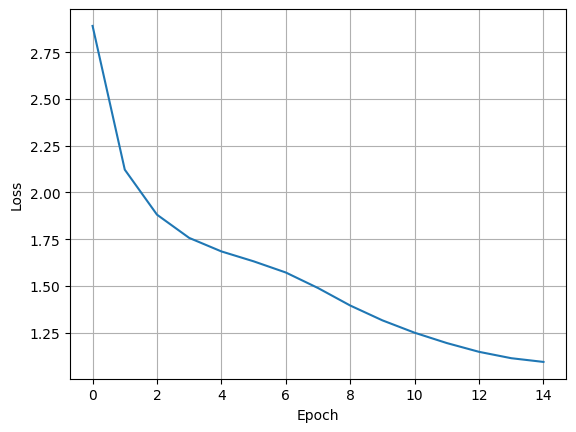

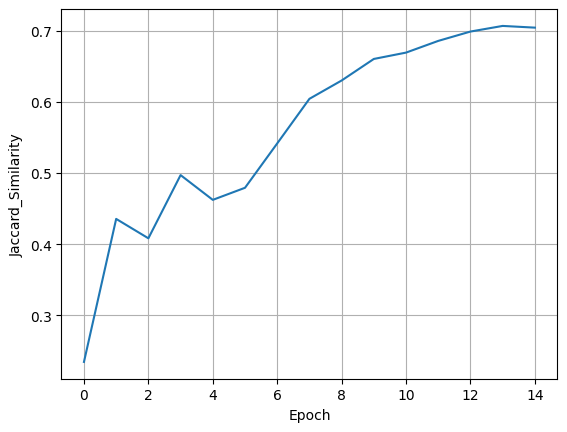

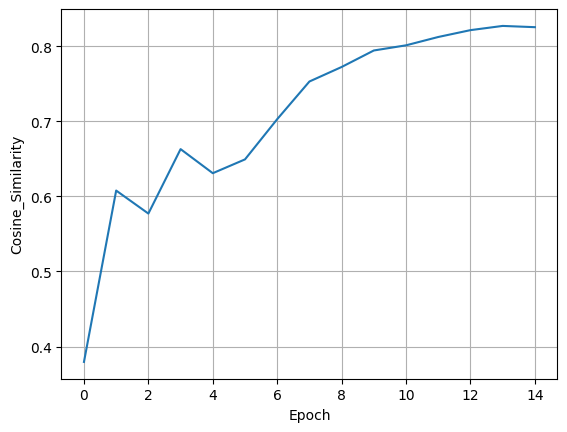

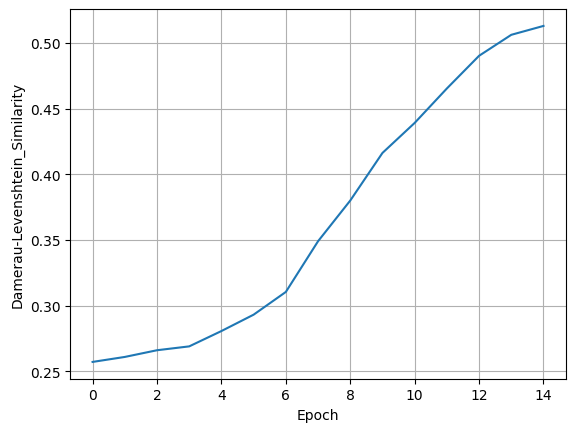

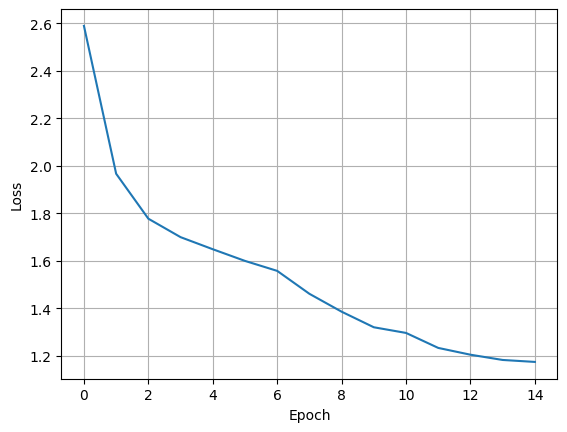

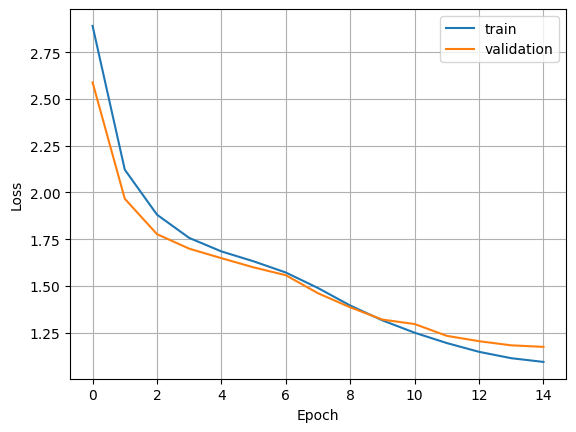

test:
{'jaccard_similarity': 0.7149286818261352, 'cosine_similarity': 0.832418468424758, 'damerau-levenshtein_similarity': 0.5086605341203023, 'loss': 1.1828287941653555}


In [33]:
if __name__ == "__main__":
    # not using absl (no need for command line), get config manually
    config = get_config()
    config.unlock()  # update hyperparams before `config.lock()`
    config.storage_folder = "./storage/attention-rnn"
    config.speech_to_text.decoder_type = DecoderType.RNN
    config.speech_to_text.decoder_kwargs = dict(
        n_layers=1,
        freq_dim=config.get_ref("n_vocab"),
        time_dim=config.get_ref("text_len"),
        hidden_dim=200,
        n_heads=2,
        feed_fwd_dim=400
    )
    config.lock()

    # Manual seed
    torch.manual_seed(config.seed)
    np.random.seed(config.seed)
    random.seed(config.seed)

    # Device to use
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using {DEVICE}")

    # Training & testing
    trainer = Trainer(config, DEVICE)
    trainer.train()
    trainer.test()

    # Plotting - check './storage/attention-rnn/{seed}/plots
    plotting(config)

## (b)

In [38]:
if __name__ == "__main__":
    # not using absl (no need for command line), get config manually
    config = get_config()
    config.unlock() # update hyperparams before `config.lock()`
    config.storage_folder = "./storage/attention-attention"
    config.speech_to_text.decoder_type = DecoderType.TRANSFORMER
    config.speech_to_text.decoder_kwargs = dict(
        freq_dim=config.get_ref("n_vocab"),
        time_dim=config.get_ref("text_len"),
        hidden_dim=200,
        n_heads=2,
        feed_fwd_dim=400
    )
    config.lock()

    # Manual seed
    torch.manual_seed(config.seed)
    np.random.seed(config.seed)
    random.seed(config.seed)

    # Device to use
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using {DEVICE}")

    # Training & testing
    trainer = Trainer(config, DEVICE)
    trainer.train()
    trainer.test()

    # Plotting - check './storage/attention-attention/{seed}/plots
    plotting(config)

Using cuda
[1]
train:
torch.Size([64, 98, 200]) torch.Size([98, 200])
torch.Size([64, 98, 200]) torch.Size([98, 200])
torch.Size([64, 98, 200]) torch.Size([98, 200])
torch.Size([64, 98, 200]) torch.Size([98, 200])
torch.Size([64, 98, 200]) torch.Size([98, 200])
torch.Size([64, 98, 200]) torch.Size([98, 200])
torch.Size([64, 98, 200]) torch.Size([98, 200])
torch.Size([64, 98, 200]) torch.Size([98, 200])
torch.Size([64, 98, 200]) torch.Size([98, 200])
torch.Size([64, 98, 200]) torch.Size([98, 200])
torch.Size([64, 98, 200]) torch.Size([98, 200])
torch.Size([64, 98, 200]) torch.Size([98, 200])
torch.Size([64, 98, 200]) torch.Size([98, 200])
torch.Size([64, 98, 200]) torch.Size([98, 200])
torch.Size([64, 98, 200]) torch.Size([98, 200])
torch.Size([64, 98, 200]) torch.Size([98, 200])
torch.Size([64, 98, 200]) torch.Size([98, 200])
torch.Size([64, 98, 200]) torch.Size([98, 200])
torch.Size([64, 98, 200]) torch.Size([98, 200])
torch.Size([64, 98, 200]) torch.Size([98, 200])
torch.Size([64, 98

KeyboardInterrupt: 